# Свёрточные сети

Сегодня мы детальнее поговорим про общие подходы при обучении нейросетей, и что происходит внутри них.

<img width='400px' src='https://raw.githubusercontent.com/sslotin/universum-dl/43390d26d5f256dcc68a6ba51998bd626b3f6d33/images/cat.png'>

Если попытаться визуализировать то, что выучивает каждый нейрон в нейросети (например, посмотрев, какие входные пиксели на него сильнее всего влияют), то можно увидеть, что чем глубже находится слой, тем более абстрактные фичи он содержит.

Например, в сетях для распознавания картинок первые слои учатся обнаруживать геометрические примитивы: линии, границы, углы. Следующий слой может распознавать простые геометрические фигуры. Следующий распознаёт наличие целых объектов и т. д.

**Weight sharing**. [Эксперименты с дропаутом](https://arxiv.org/abs/1701.05369) показывают, что в линейном слое примерно 99% весов на самом деле можно выкинуть. Логично, что в оптимальной архитектуре не должно быть бесполезных весов — лишние параметры всегда ведут к переобучению. В случае с картинками решение в том, чтобы использовать информацию о расположении пикселей относительно друг друга.

## Свёртки и пуллинги

**Как хранятся картинки**. Когда говорят «изображение», представляйте не прямоугольник, а параллелепипед, высотой которого будет размер каналов. Например, обычные цветные RGB картинки имеют 3 канала: на красный (R), зелёный (G) и синий (B).

0. Введем такую функцию, как **ядро** (англ. **kernel**) — она считает скалярное произведение вектора-входа со своим вектором-параметром.
1. Разобьем исходный паралеллелепипед на сколько-то параллелепипедов одинакового размера вдоль размерности, соответствующей каналам. Они могут пересекаться.
2. Каждый из них «разгладим» в вектор.
3. К кажому такому вектору и применим по очереди каждый кернел (их обычно берут много разных).
4. Положим то, что получилось, в новый параллелепипед.
5. Посчитаем для кажой ячейки какую-нибудь нелинейность. Обычно это ReLU из-за вычислительных причин.

<img width='350px' src='https://raw.githubusercontent.com/sslotin/universum-dl/43390d26d5f256dcc68a6ba51998bd626b3f6d33/images/conv1.png'>

Эта операция называется **свёрткой**. Помимо кернела, в ней есть другие параметры — паддинг (отступ по краям), страйды (шаги по x и y). Также свёртка может быть в 2d и 3d. Посмотрите этот репозиторий, чтобы получше разобраться со свёрточной арифметикой: https://github.com/vdumoulin/conv_arithmetic

![](http://deeplearning.net/software/theano/_images/numerical_padding_strides.gif)

**Пулингом** называют операцию, при которой входной тензор так же разбивается на квадраты (не паралепипеды — операция независима по каждому каналу) и на каждом квадрате считается какая-нибудь редукция (чаще всего максимум или среднее по всем значениям в квадрате), после чего полученные значения записываются на следующий слой в том же порядке.

<img width='400px' src='http://cs231n.github.io/assets/cnn/maxpool.jpeg'>

В свёртках переиспользуется очень много параметров: кернел для каждого фильтра (выходного канала) использует один и тот же вектор-параметр для скалярного умножения. Из-за этого каждый фильтр как правило выучивает какую-то конкретную фичу, вроде наличия какого-либо объекта на своём регионе. Пулинг используют затем для понижения размерности: каждый нейрон после свертки выражает степень уверенности, что на регионе присутствует какой-то объект, и поэтому логично в качестве вероятности наличия объекта на регионе из под-регионов использовать максимум или среднее.

Чаще всего используют свёртки 3x3 со страйдом 2x2 (то есть квадраты перекрываются по 3 крайним пикселям) с пулингом размера 2x2 (не перекрываются).

## Аугментация данных

Аугментацией называется процесс получения новых синтетических данных из имеющихся, чтобы подать в обучение. Это часто (особенно в компьютерном зрении) позволяет улучшить качество модели, не используя дополнительных данных.

Формально, в случае с классификацией, аугментация — это любое преобразование, которое корректно изменяет данные, не меняя их класс.

В случае с картинками, можно попробовать добавить следующие преобразования, которые с какой-то вероятностью будут использоваться во время обучения:

* Поворот на малый угол.
* Добавление шума.
* Обрезание границ и последующее растяжение до исходного размера.
* Горизонтальное отражение (но в нашем случае оно вредно).
* Смещение на небольшое расстояние.

Понятно, что лейбл эти преобразования изменить не должны.

<img src='https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/a5da2c3b4174449d13dd746b7d00897c6bc1f334/5-Figure2-1.png' width='500px'>

## Взрывающийся градиент

В сетях происходит очень много чего стохастического: батч формируется случайно, аугментация, рандомизированные слои вроде дропаута, вычислительные ошибки. Это всё может привести к тому, что сеть на какой-то итерации будет очень уверенна в неправильном предсказании и некоторые её параметры получат очень большой градиент. Это может привести к тому, что эти параметры «улетят» куда-то настолько далеко, и после этого сеть будет всегда предсказывать класс, который на этой итерации был правильным. 

Простое решение: просто обрезать градиент в случае, если градиент больше какого-то фиксированного значения. Для этого есть функция `torch.nn.utils.clip_grad_norm_`, которая принимает параметры модели и параметр `threshold`. Она считает норму (длину вектора) градиента и, если она больше `threshold`, нормирует градиенты так, чтобы она была равна `threshold`. Эта функция также возвращает само значение нормы, что может быть очень полезно при анализе обучения (например, если она становится маленькой, то, значит, сеть сходится к какому-то плато).

## Инициализация параметров

Сначала приведем пример плохой инициализации. Пусть мы задали все значения изначально нулями. В таком случае наша модель становится эквивалентна линейной модели — производная по функции потерь одинакова для каждого $w_i$, таким образом, все веса имеют одинаковые значения и в последующей итерации, что делает нейроны в сети симметричными.

Подход получше — инициализировать каждый вес случайно. Но тут нужно быть осторожным — если задать их слишком большими, то сеть может быть изначально очень уверенна в своих предсказаниях, и подвинуть параметры оттуда будет очень трудно.

Решение следующее. С точки зрения слоя, ему на вход подается сэмпл из какого-то распределения, и он под это распределение подстраивается. В нейросетях размеры слоев достаточно большие, чтобы в них работали законы статистики, все разработчики фреймворках условились инициализировать веса всех слоев в предположении, что на вход подаются данные из какого-то распределения со средним 0 и дисперсией 1, и на выходе должно получиться какое-то распределение со средним тоже 0 и дисперсией 1. Чаще всего изначальные веса берут либо из нормального, либо из равномерного распределения, «обрезанного» так, чтобы дисперсия каждого выходного значения получилась единичной.

Аналогично нужно поступать со входными векторными данными: нормализовывать. Это будет важно при работе с изображениями: не надо подавать на вход вектора с элементами от 0 до 255. Самое простое рабочее решение — нормализовать вход, поделив его на 255.

## Минутка физики

Потребляемая энергия в сети с переменным током в единицу времени считается по формуле

$$W = CV^2f$$

где $C$ означает емкость сети, $V$ означает напряжение, а $f$ — частоту. В случае с процессорами, это именно та частота, с которой выполняются элементарные операции, например сложение.

<img width='350px' src='https://i.ibb.co/yhsGRJK/Screenshot-from-2019-02-08-14-52-07.png'>

Однако, если мы сделаем сеть из двух параллельно подключенных процессоров, работающих на половинной частоте, мы можем получить сеть, потребляющую ~40% изначальной энергии, делающую то же количество полезной работы — то же суммарное количество процессорных тактов:

<img width='450px' src='https://i.ibb.co/WgLCxxL/Screenshot-from-2019-02-08-14-52-18.png'>

Поэтому для хорошо распараллеливаемых операций используют другой тип вычислительных устройств, в которых не 4-8 быстрых (3-4 GHz) процессоров, а несколько тысяч медленных (~1GHz).

## Device-agnostic код

К любой модели или тензору в PyTorch можно применить `.cuda()` и `.cpu()`, чтобы перевести тензор на память GPU или в оперативную память соответственно. Но если мы будем писать такой код, нам будет довольно проблематично портировать его на другие машины, где, например, нет GPU (например, если вы хотите скачать тетрадку с colab к себе и запустить).

Многие фреймворки позволяют абстрагироваться от устройства конкретных вычислительных устройств. В PyTorch для этого есть объект `torch.device`, который позволяет явно задавать, на каком устройстве хранить тензор или модель.

In [1]:
import torch
import torch.nn as nn

device = torch.device('cuda:0')  # используй первую GPU (номеруются с нуля)

X = torch.randn(5, 100, device=device)  # создай матрицу на этом устройстве
# альтернативно: X = X.to(device)

# создадим какую-нибудь модель
model = nn.Sequential(
    nn.Linear(100, 20),
    nn.ReLU(),
    nn.Linear(20, 8)
)

model = model.to(device)  # переведи параметры модели на это устройство

model(X)

tensor([[ 0.1343,  0.5615, -0.1695,  0.3561, -0.0892, -0.3539,  0.2998, -0.0316],
        [ 0.0326,  0.4426, -0.4977, -0.0245,  0.2520, -0.2913,  0.1549,  0.0263],
        [ 0.0107,  0.4551, -0.4723, -0.1438,  0.3940,  0.0778,  0.1006, -0.1821],
        [ 0.0742,  0.4012, -0.2494,  0.2811,  0.1671, -0.1920,  0.2936, -0.0834],
        [-0.0029,  0.1277, -0.2903, -0.1983,  0.1740,  0.0139,  0.0962, -0.3365]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

# Колоризация изображений

Начнём практическую часть. Обучим autoencoder-like сеть, которая учится восстанавливать изображение по его черно-белой версии. В качестве лосса будем так же использовать какую-нибудь меру расстояния между изображениями (например, l1 или l2).

Тот пайплайн, что у нас получится, с минимальными изменениями можно будет также использовать и для других подобных задач, связанных с восстановлением изображений после каких-либо необратимых преобразований, например после подмешивании шума (denoising autoencoder) или понижения размера (DeepHD).

![](https://camo.githubusercontent.com/c5f95c94d70a3e52561c1d0591e84a5e3b86eb74/687474703a2f2f726963687a68616e672e6769746875622e696f2f636f6c6f72697a6174696f6e2f7265736f75726365732f696d616765732f6e65745f6469616772616d2e6a7067)

In [2]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Для начала скачаем данные. Годятся вообще любые изображения, не обязательно из какого-то изветсного датасета. Этой командой можно скачать и распакавать фотографии с одной школы по программированию, проходившей этим летом.

In [3]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar

--2022-04-17 17:37:02--  http://sereja.me/f/universum_compressed.tar
Resolving sereja.me (sereja.me)... 213.159.215.132
Connecting to sereja.me (sereja.me)|213.159.215.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72028160 (69M) [application/x-tar]
Saving to: ‘universum_compressed.tar’

universum_compresse 100%[===================>]  68.69M  7.00MB/s    in 18s     

2022-04-17 17:37:21 (3.80 MB/s) - ‘universum_compressed.tar’ saved [72028160/72028160]



Есть два подхода к работе с данными:

1. Сначала преобразовать все имеющиеся данные к виду, который принимает нейросеть (сразу к тензорам одинакового размера).
2. Хранить сырые данные и преобразование препроцессинга (функцию) и собирать батчи на лету.

Если это не что-то совсем простое, то второй вариант предпочтительнее, так как он не требует дополнительной памяти (датасеты могут быть большими), времени на векторизацию датасета, а так же сбор батча «на лету» позволяет там же делать аугментацию.

Для этого в PyTorch есть две абстракции: `Dataset` и `DataLoader`.

`Dataset` — абстрактный класс, от которого нужно отнаследовать класс датасета, который мы напишем. В нём должны быть определён конструктор (в нём обычно загружаются в память сырые данные, которые лежат где-то на диске, а также сохраняется какая-нибудь другая информация), метод `__len__` (должен вернуть размер датасета) и `__getitem__`, который должен по номеру сэмпла вернуть его в виде тензора (возможно, произведя какой-нибудь препроцессинг).

In [4]:
# tqdm -- это маленькая библиотечка для прорисовывания progress bar-ов прямо в питоне

from tqdm import tqdm
from time import sleep

#for i in tqdm(range(10)):
#    sleep(0.5)

In [5]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass
                #print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

Чтобы подавать картинки на вход нейросети, нужно их перевести в тензоры, причём одинакового размера.

In [6]:
transform_all = transforms.Compose([
    # вырежем случайный квадратик
    transforms.RandomResizedCrop(128),
    # горизонтально перевернем -- изображение останется валидным
    transforms.RandomHorizontalFlip(),
    # что бы ещё поделать, чтобы увеличить размер датасета?
    # ...
    transforms.ToTensor(),
])

def to_grayscale(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)
    # минутка эволюционной биологии: как вы думаете, почему коэффициенты именно такие?

Здесь `transform_all` и `to_grayscale` являются функциями (формально, первый является функтором), которые мы передадим дальше в `DataLoader`, который оборачивает датасет и позволяет итерироваться по нему по батчам, а также реализует разные полезные функции вроде перемешивания данных после каждой эпохи.

In [7]:
dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 1254/1254 [00:01<00:00, 695.40it/s]


**Skip-connection**. Иногда бывает полезно присоединить к выходу какого-то слоя его вход, чтобы следующий получил такую же, неизменённую копию. Здесь мы поступим именно так: подадим исходное черно-белое изображение в какую-то одну часть сети, которая сконцентрируется на определении цвета, а затем припишем последним слоем её выход и отправим дальше другому модулю, который уже раскрасит это исходное изображение. От простоты `nn.Sequential`, правда, уже придётся отказаться, и нужно написать свой класс.

In [8]:
from torch.nn import BatchNorm2d

In [20]:
def Block(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
        #nn.BatchNorm2d(channels_out),
        nn.ReLU(),
        # nn.MaxPool2d(),
        #nn.Dropout(p=0.3)
        
    )
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
            Block(1,64),
            nn.MaxPool2d((2,2)),
            Block(64,128),
            nn.MaxPool2d((2,2)),
            Block(128,256),
            Block(256,256),
            nn.MaxPool2d((2,2)),
            Block(256,256),
            nn.Upsample(scale_factor=2),
            Block(256,128),
            Block(128,128),
            nn.Upsample(scale_factor = 2),
            Block(128,128),
            Block(128,128),
            nn.Upsample(scale_factor = 2),
            Block(128,64)
        )
         
        self.postconcat = nn.Sequential(         # эту сетку можно особо не увеличивать - она не должна быть очень умной
            nn.Conv2d(65, 32, (3, 3), padding=1),# подумайте, откуда у автора тут 65
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        # исходное чб изображение -- просто дополнительным слоем
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

Глубокие сети очень часто состоят из повторяющихся блоков, отличающихся только размерностью (в данном случае — количеством фильтров). Чтобы сократить количество кода и уменьшить вероятность багов, блоки можно обернуть в одну функцию, возвращающую мини-модель из нескольких слоев.

Концептуальный пример:

Дальше как обычно:

In [21]:
num_epochs = 150
lr = 1e-3

model = Colorizer().to(device)
torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.L1Loss()  # тут можно поиграться с лоссами

In [22]:
history = []
for epoch in range(num_epochs):
    for x, y in loader:

      x = x.to(device)
      y = y.to(device)

      optimizer.zero_grad()

      colorized = model(x)
      loss = criterion(colorized, y)
      
      history.append(loss.item())
      
      loss.backward()
      optimizer.step()
        # теперь сами:
        # 0. распакавать данные на нужное устройство
        # 1. сбросить градиент
        # 2. прогнать данные через сеть
        # 3. посчитать loss
        # 4. залоггировать его куда-нибудь
        # 5. сделать .backward()
        # 6. optimizer.step()
        # (7. вывести пример колоризации -- см код ниже)

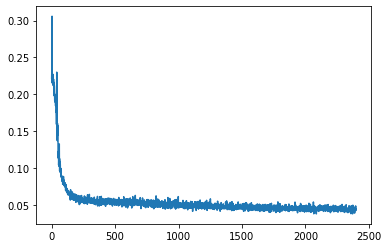

In [23]:
plt.plot(history)
plt.show()

В подобных нечётко поставленных задачах важно смотреть не цифры, а на реальные примеры.


In [24]:
def to_numpy_image(img):
    # tl;dr: PyTorch хочет (3, 128, 128), а plt.imshow хочет (128, 128, 3)
    # есть два популярных формата для цветных картинок:
    #  1. где размерность, соответствующая каналам, идёт последней
    #  2. где размерность, соответствующая каналам, идёт первой
    # при работе с нейросетями удобен первый подход -- так запрашиваемая
    # при вычислениях память идёт последовательно, и из-за кэширования
    # операции свёртки работают быстрее
    # второй подход удобнее при уже работе с устройством, которое эти картинки показывает
    # -- удобно на три лампочки послать сразу три последовательно идущих байта
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

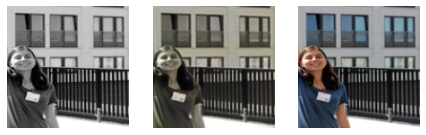

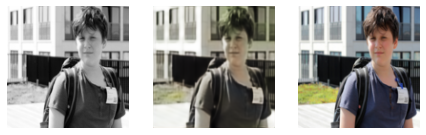

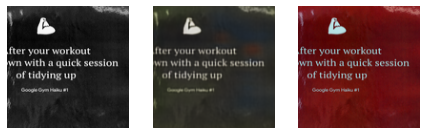

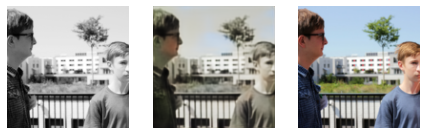

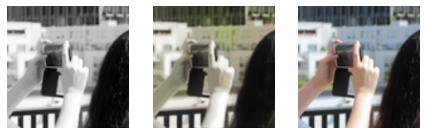

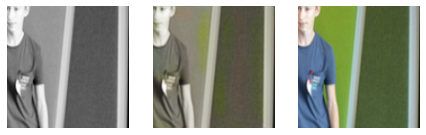

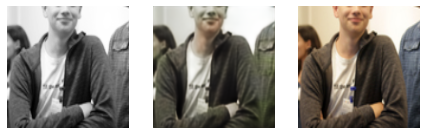

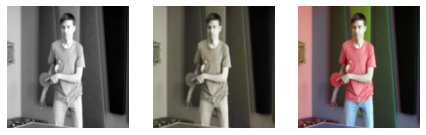

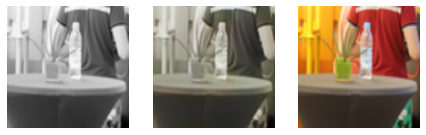

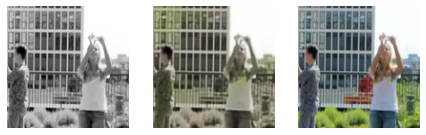

In [34]:
for t in range(10):
    img_gray, img_true = dataset[t]
    img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
    img_pred = to_numpy_image(img_pred)
    # теперь это numpy-евский ndarray размера (128, 128, 3)
    plt.figure(figsize=(10,10))
    
    plt.subplot(141)
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_gray.reshape((128, 128)))

    plt.subplot(142)
    plt.axis('off')
    plt.imshow(img_pred.reshape((128, 128, 3)))

    plt.subplot(143)
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))
    
    plt.show()

## *Тизер: adversarial loss

У нашего подхода к колоризации есть одна весьма существенная проблема: непонятно, как определять функцию потерь. Выясняется, что l1 или l2 в некоторых случаях даже являются принципиально неправильным выбором. Представьте, что у нас есть датасет фотографий с летнего лагеря, в котором все люди ходят в футболках двух разных цветов — например, красного и синего — интенсивность которых одинакова и неотличима на черно-белых версиях. Тогда наш лосс заставит сеть выбирать что-то «по середине» (в случае с l2 это будет среднее, а с l1 медиана), и, скорее всего, она сгенерирует что-то серое, в то время как она должна с какой-то вероятностью сгенерировать явно красную или явно синюю футболку.

Решение в следующем: выход (колоризованное изображение) кормить в другую сеть, которая учится определять «правдоподобность» раскраски. Помимо восстановления изображения с точки зрения какой-то меры близости, сети-генератору (колоризатору) нужно ещё и обмануть сеть-дискриминатор, а сети-дискриминатору нужно наоборот, учиться отличать настоящую колоризацию от нашей.

Подобные схемы с двумя состязяющимися сетями называют GAN-ам (Generative Adversarial Networks), о которых мы поговорим через занятие.